In [25]:
# --- Jupyter notebook setup ---
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# --- Numpy i osnovne biblioteke ---
import numpy as np

# --- Funkcija koju optimizujemo (primer: Schwefel 2D) ---
def schwefel_2d(x, y):
    """Schwefel funkcija u 2D: globalni minimum ~ (420.9687, 420.9687)"""
    return 418.9829*2 - (x*np.sin(np.sqrt(abs(x))) + y*np.sin(np.sqrt(abs(y))))


In [26]:
# BAZNA KLASA: Explorer
class Explorer:
    def __init__(self, dim, bounds, w, c1, c2):
        self.position = np.random.uniform(bounds[:,0], bounds[:,1])
        self.velocity = np.random.uniform(-0.1*(bounds[:,1]-bounds[:,0]), 
                                          0.1*(bounds[:,1]-bounds[:,0]))
        self.best_position = self.position.copy()
        self.best_value = float('inf')
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def update_velocity(self, global_best):
        r1 = np.random.rand(len(self.position))
        r2 = np.random.rand(len(self.position))
        cognitive = self.c1 * r1 * (self.best_position - self.position)
        social = self.c2 * r2 * (global_best - self.position)
        self.velocity = self.w * self.velocity + cognitive + social

    def update_position(self, bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, bounds[:,0], bounds[:,1])

# TIPOVI EXPLORERA
class Adventurer(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.9, c1=1.2, c2=1.2)

class Aggressive(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.4, c1=2.2, c2=2.4)

class Standard(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.7, c1=1.7, c2=1.7)

class Innovative(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.6, c1=2.0, c2=1.8)
    def update_position(self, bounds):
        super().update_position(bounds)
        if np.random.rand() < 0.1:
            self.position += np.random.normal(0, 0.1, len(self.position))
            self.position = np.clip(self.position, bounds[:,0], bounds[:,1])


In [27]:
# TVAC po tipu
def tvac_coefficients_by_type(iteration, max_iter):
    coeffs = {}
    coeffs['Adventurer'] = (0.9 - 0.5*iteration/max_iter,
                            1.2 + 0.8*iteration/max_iter,
                            1.2 - 0.7*iteration/max_iter)
    coeffs['Aggressive'] = (0.4 + 0.3*iteration/max_iter,
                            2.2 - 0.7*iteration/max_iter,
                            2.4 - 0.6*iteration/max_iter)
    coeffs['Standard'] = (0.7 - 0.3*iteration/max_iter,
                          1.7 + 1.2*iteration/max_iter,
                          1.7 - 1.2*iteration/max_iter)
    coeffs['Innovative'] = (0.6 - 0.3*iteration/max_iter,
                            2.0 - 1.0*iteration/max_iter,
                            1.8 - 1.0*iteration/max_iter)
    return coeffs

In [28]:
# HETEROGENI PSO
def pso_heterogeneous(num_iters, swarm, bounds, f):
    types = ['Adventurer','Aggressive','Standard','Innovative']
    history_positions_by_type = {t: [] for t in types}
    history_coeffs_by_type = {t: {'w':[], 'c1':[], 'c2':[]} for t in types}

    # Inicijalni global best
    global_best_value = float('inf')
    global_best_position = None
    for p in swarm:
        val = f(p.position[0], p.position[1])
        if val < global_best_value:
            global_best_value = val
            global_best_position = p.position.copy()
        p.best_value = val
        p.best_position = p.position.copy()

    for it in range(num_iters):
        # TVAC parametri po tipu
        coeffs = tvac_coefficients_by_type(it, num_iters)
        for p in swarm:
            t = p.__class__.__name__
            p.w, p.c1, p.c2 = coeffs[t]
            p.update_velocity(global_best_position)
            p.update_position(bounds)
            val = f(p.position[0], p.position[1])

            # Lični best
            if val < p.best_value:
                p.best_value = val
                p.best_position = p.position.copy()
            # Globalni best
            if val < global_best_value:
                global_best_value = val
                global_best_position = p.position.copy()

        # Čuvanje istorije
        for t in types:
            positions_of_type = [p.position.copy() for p in swarm if p.__class__.__name__ == t]
            history_positions_by_type[t].append(positions_of_type)
            ws = np.mean([p.w for p in swarm if p.__class__.__name__ == t])
            c1s = np.mean([p.c1 for p in swarm if p.__class__.__name__ == t])
            c2s = np.mean([p.c2 for p in swarm if p.__class__.__name__ == t])
            history_coeffs_by_type[t]['w'].append(ws)
            history_coeffs_by_type[t]['c1'].append(c1s)
            history_coeffs_by_type[t]['c2'].append(c2s)

    return global_best_position, global_best_value, history_positions_by_type, history_coeffs_by_type


In [62]:
def run_heterogeneous_team(num_adventurer, num_aggressive, num_standard, num_innovative,
                           num_iters=300, bounds=np.array([[-500,500], [-500,500]]),
                           dim=2, f=schwefel_2d, show_plot=True, verbose=True):
    """
    Pokreće PSO sa TVAC za heterogeni tim i vraća rezultate.
    Ako show_plot=False, ne prikazuje graf (koristi se za batch testove).
    """
    swarm = []
    swarm += [Adventurer(dim, bounds) for _ in range(num_adventurer)]
    swarm += [Aggressive(dim, bounds) for _ in range(num_aggressive)]
    swarm += [Standard(dim, bounds) for _ in range(num_standard)]
    swarm += [Innovative(dim, bounds) for _ in range(num_innovative)]
    
    global_best_pos, global_best_val, history_positions, history_coeffs = pso_heterogeneous(
        num_iters=num_iters,
        swarm=swarm,
        bounds=bounds,
        f=f
    )

    global_best_history = []
    for i in range(num_iters):
        best_vals = [min([f(*p) for p in history_positions[t][i]]) for t in history_positions.keys() if history_positions[t][i]]
        if best_vals:
            global_best_history.append(min(best_vals))
    global_best_history = np.array(global_best_history)
    
    delta = np.diff(global_best_history)
    avg_convergence_rate = -np.mean(delta) if len(delta) > 0 else np.nan

    if verbose:
        print(f"Team A={num_adventurer}, Ag={num_aggressive}, S={num_standard}, I={num_innovative}")
        print("  Globalni najbolji:", global_best_pos)
        print("  Vrednost:", global_best_val)
        print("  Avg convergence rate:", avg_convergence_rate)
    
    if show_plot:
        plt.figure(figsize=(10,6))
        plt.plot(global_best_history, color='black', label='Globalni najbolji')
        plt.xlabel("Iteracija")
        plt.ylabel("Vrednost funkcije")
        plt.title(f"Konvergencija heterogenog tima - brzina ≈ {avg_convergence_rate:.4f}")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return global_best_pos, global_best_val, global_best_history, avg_convergence_rate


Team A=2, Ag=2, S=16, I=2
  Globalni najbolji: [-302.52493583  420.96874678]
  Vrednost: 118.43836006957031
  Avg convergence rate: 0.402243879164879


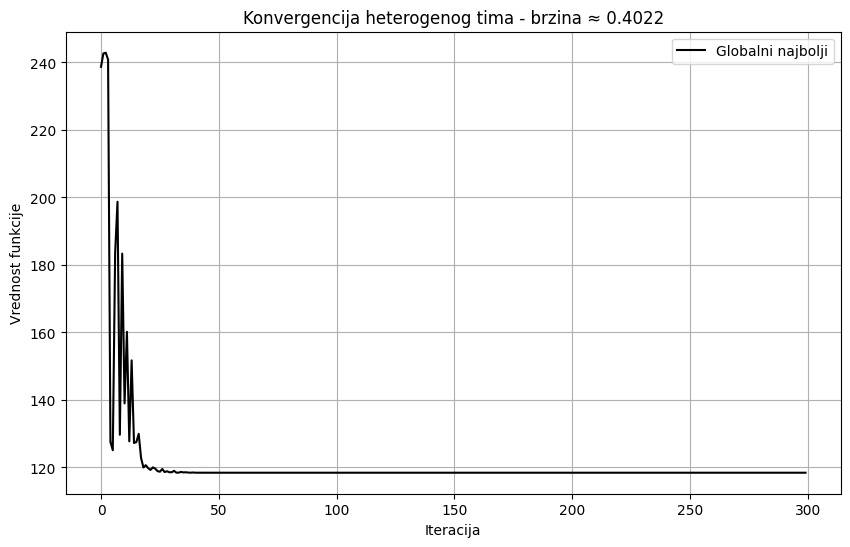

In [63]:
run_heterogeneous_team(2, 2, 16, 2);

In [64]:
def plot_multiple_heterogeneous_teams(team_configs, num_iters=300,
                                      bounds=np.array([[-500,500], [-500,500]]),
                                      dim=2, f=schwefel_2d):
    """
    Pokreće više heterogenih timova i prikazuje njihove konvergencije na istom grafiku.
    """
    plt.figure(figsize=(10,6))
    
    for team in team_configs:
        num_adventurer, num_aggressive, num_standard, num_innovative = team
        
        # Tiho pokretanje bez individualnih grafika
        _, _, global_best_history, avg_convergence_rate = run_heterogeneous_team(
            num_adventurer, num_aggressive, num_standard, num_innovative,
            num_iters=num_iters, bounds=bounds, dim=dim, f=f,
            show_plot=False, verbose=False
        )
        
        label = f"A={num_adventurer}, Ag={num_aggressive}, S={num_standard}, I={num_innovative}"
        plt.plot(global_best_history, label=f"{label} | avg ≈ {avg_convergence_rate:.4f}")
    
    plt.xlabel("Iteracija")
    plt.ylabel("Vrednost funkcije")
    plt.title("Uporedna konvergencija različitih heterogenih timova")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


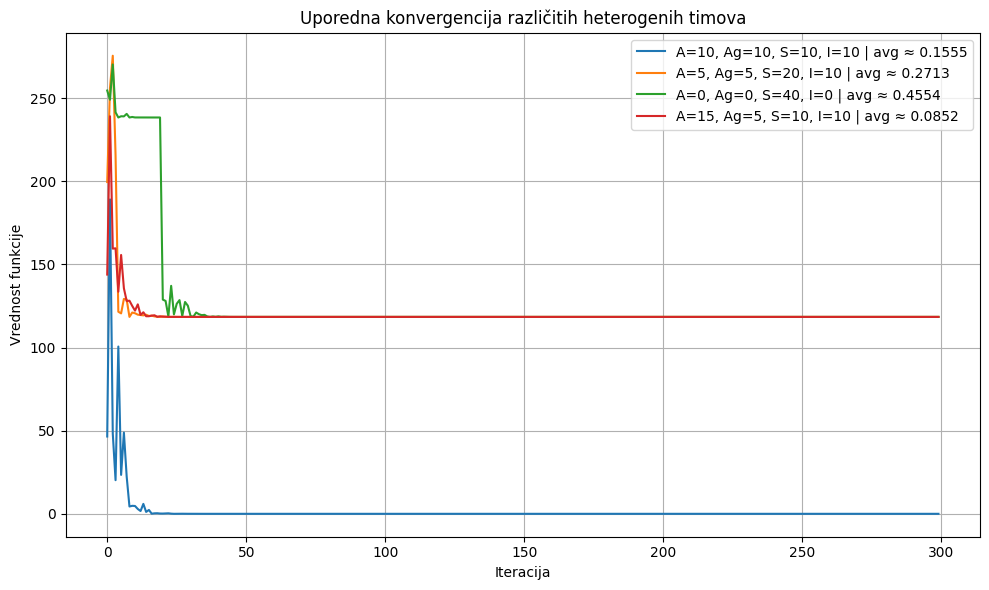

In [67]:
team_configs = [
    (10, 10, 10, 10),   # ravnomerno
    (5, 5, 20, 10),     # više standardnih
    (0, 0, 40, 0),      # samo standardni
    (15, 5, 10, 10),    # više avanturista
]

plot_multiple_heterogeneous_teams(team_configs)
